In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn


# Baca file CSV
df = pd.read_csv("Book1.csv")

# Validasi kolom (optional)
expected_cols = ['ipk', 'progress', 'kehadiran', 'organisasi', 'magang', 'sks', 'kategori']
assert all(col in df.columns for col in expected_cols), "Kolom tidak lengkap"

# Ambil fitur dan target
features = df[['ipk', 'progress', 'kehadiran', 'organisasi', 'magang', 'sks']].values

# Label encoding target
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(df['kategori'])  # Mengubah kategori jadi angka

# Konversi ke tensor
x_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.long)  # Untuk klasifikasi (misal pakai CrossEntropyLoss)

# Cek bentuk tensor
print("Input shape:", x_tensor.shape)
print("Target shape:", y_tensor.shape)


Input shape: torch.Size([20, 6])
Target shape: torch.Size([20])


In [5]:
# Normalisasi input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

x_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.long)  # <-- ini penting untuk CrossEntropyLoss



# Sigma harus float dan positif
class GaussianMF(nn.Module):
    def __init__(self, mean, sigma):
        super().__init__()
        self.mean = nn.Parameter(torch.tensor(float(mean)))
        self.sigma = nn.Parameter(torch.tensor(float(sigma)))

    def forward(self, x):
        sigma = torch.clamp(self.sigma, min=1e-3)
        return torch.exp(-0.5 * ((x - self.mean) / sigma) ** 2)



In [6]:
class ANFIS(nn.Module):
    def __init__(self, n_inputs=6, mfs_per_input=2, n_classes=3):  # tambah argumen n_classes
        super().__init__()
        self.n_inputs = n_inputs
        self.mfs_per_input = mfs_per_input
        self.n_rules = mfs_per_input ** n_inputs
        self.n_classes = n_classes

        self.mf_layers = nn.ModuleList([
            nn.ModuleList([GaussianMF(mean=0.5 + i, sigma=1.0) for i in range(mfs_per_input)])
            for _ in range(n_inputs)
        ])

        # rule_weights sekarang shape: [n_rules, n_inputs + 1, n_classes]
        # karena tiap rule punya parameter linear untuk tiap kelas
        self.rule_weights = nn.Parameter(torch.randn(self.n_rules, n_inputs + 1, n_classes))

    def forward(self, x):
        batch_size = x.size(0)

        mf_values = []
        for i in range(self.n_inputs):
            mf_x = [mf(x[:, i]) for mf in self.mf_layers[i]]
            mf_values.append(torch.stack(mf_x, dim=1))

        from itertools import product
        rule_indices = list(product(range(self.mfs_per_input), repeat=self.n_inputs))

        firing_strengths = []
        for idx in rule_indices:
            rule_mfs = [mf_values[i][:, idx[i]] for i in range(self.n_inputs)]
            prod = torch.stack(rule_mfs, dim=0).prod(dim=0)
            firing_strengths.append(prod)

        firing_strengths = torch.stack(firing_strengths, dim=1)
        norm_strengths = firing_strengths / torch.sum(firing_strengths, dim=1, keepdim=True)

        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # [batch, n_inputs+1]

        # Hitung consequent untuk semua kelas:
        # x_aug shape: [batch, n_inputs+1]
        # rule_weights shape: [n_rules, n_inputs+1, n_classes]
        # output tiap rule per kelas: [batch, n_rules, n_classes]
        consequent = torch.einsum('bi,rij->brj', x_aug, self.rule_weights)  # einsum buat dot product

        # normalisasi dan agregasi per kelas
        # norm_strengths shape: [batch, n_rules], consequent: [batch, n_rules, n_classes]
        output = torch.sum(norm_strengths.unsqueeze(-1) * consequent, dim=1)  # [batch, n_classes]

        return output


In [7]:

model = ANFIS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


for epoch in range(200):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 1.6307
Epoch 20 - Loss: 0.4810
Epoch 40 - Loss: 0.3306
Epoch 60 - Loss: 0.2367
Epoch 80 - Loss: 0.1665
Epoch 100 - Loss: 0.1122
Epoch 120 - Loss: 0.0709
Epoch 140 - Loss: 0.0435
Epoch 160 - Loss: 0.0284
Epoch 180 - Loss: 0.0200


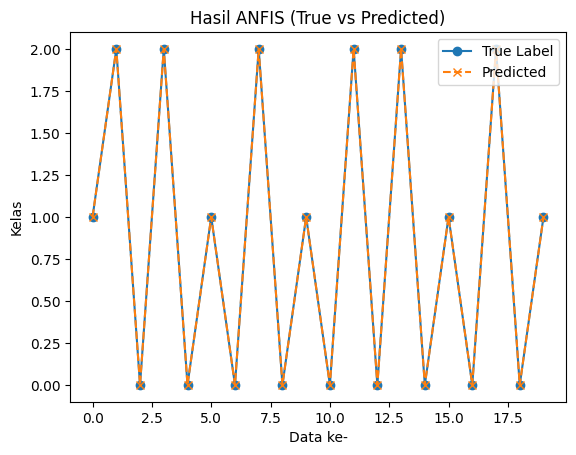

In [8]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    output = model(x_tensor)               # [batch, n_classes]
    pred = torch.argmax(output, dim=1).numpy()  # ambil prediksi kelas
    true = y_tensor.numpy()                     # label asli

plt.plot(true, label="True Label", marker='o')
plt.plot(pred, label="Predicted", linestyle='--', marker='x')
plt.legend()
plt.title("Hasil ANFIS (True vs Predicted)")
plt.xlabel("Data ke-")
plt.ylabel("Kelas")
plt.show()


In [9]:
new_data = [[3.5, 80, 90, 1, 0, 120]]
new_data_scaled = scaler.transform(new_data)
new_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    output = model(new_tensor)  # Output shape: [1, n_classes]
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = label_encoder.inverse_transform([pred_class])[0]  # Jika ingin nama kelas

    print("Prediksi (kelas index):", pred_class)
    print("Prediksi (label):", pred_label)


Prediksi (kelas index): 0
Prediksi (label): Butuh Perhatian
